In [403]:
import pandas as pd
import numpy as np
from math import sqrt, atan2
import pywt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy.signal as signal
from hampel import hampel
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import math
import difflib
import pandas as pd
import matplotlib.pyplot as plt
import collections


In [404]:
path ='rawcsi/mayank_ISA.csv'

In [405]:
# read the input CSI file.
def fine_csv(path):
    df = pd.read_csv(path, sep=",", header=0) 
    index_names = df[df['mac'] != 'C4:4F:33:7B:83:7E'].index
    df.drop(index_names, inplace = True)
    df = df.dropna()
    # reset the index 
    df = df.reset_index(drop=True)
    print("fine_csv completed")
    return df

In [406]:
# call here
df = fine_csv(path)

fine_csv completed


In [407]:
df

,type,role,mac,rssi,rate,sig_mode,mcs,bandwidth,smoothing,not_sounding,...,secondary_channel,local_timestamp,ant,sig_len,rx_state,real_time_set,real_timestamp,len,CSI_DATA,timestamp
0,CSI_DATA,STA,C4:4F:33:7B:83:7E,-53,11,0,0,0,0,0,...,1,102470,0,131,0,0,0.286424,128,[-125 48 8 0 0 0 0 0 0 0 0 0 2 24 1 24 2 25 2 ...,1.660285e+09
1,CSI_DATA,STA,C4:4F:33:7B:83:7E,-57,11,0,0,0,0,0,...,1,3642039,0,37,0,0,3.826230,128,[37 80 2 0 0 0 0 0 0 0 0 0 27 3 27 4 27 4 28 3...,1.660285e+09
2,CSI_DATA,STA,C4:4F:33:7B:83:7E,-58,11,0,0,0,0,0,...,1,4713743,0,37,0,0,4.897740,128,[37 80 2 0 0 0 0 0 0 0 0 0 -26 18 -25 17 -26 1...,1.660285e+09
3,CSI_DATA,STA,C4:4F:33:7B:83:7E,-58,11,0,0,0,0,0,...,1,4717720,0,37,0,0,4.903910,128,[37 80 2 0 0 0 0 0 0 0 0 0 17 -28 17 -27 16 -2...,1.660285e+09
4,CSI_DATA,STA,C4:4F:33:7B:83:7E,-62,11,1,3,1,1,1,...,1,6998616,0,110,0,0,7.182740,384,[110 96 6 0 0 0 0 0 0 0 0 0 12 20 12 19 12 19 ...,1.660285e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27027,CSI_DATA,STA,C4:4F:33:7B:83:7E,-64,11,1,3,1,1,1,...,1,540034466,0,110,0,0,540.228000,384,[110 96 6 0 0 0 0 0 0 0 0 0 14 17 13 16 13 16 ...,1.660286e+09
27028,CSI_DATA,STA,C4:4F:33:7B:83:7E,-64,11,1,3,1,1,1,...,1,540066164,0,110,0,0,540.250000,384,[110 96 6 0 0 0 0 0 0 0 0 0 -14 19 -14 18 -14 ...,1.660286e+09
27029,CSI_DATA,STA,C4:4F:33:7B:83:7E,-64,11,1,3,1,1,1,...,1,540069844,0,110,0,0,540.267000,384,[110 96 6 0 0 0 0 0 0 0 0 0 -22 -3 -21 -3 -22 ...,1.660286e+09
27030,CSI_DATA,STA,C4:4F:33:7B:83:7E,-64,11,1,3,1,1,1,...,1,540087056,0,110,0,0,540.285000,384,[110 96 6 0 0 0 0 0 0 0 0 0 -24 9 -23 8 -23 8 ...,1.660286e+09


In [408]:
# prepare matrix from the raw data. 
def prepare_matrix(CSI_DATA):
    #df = pd.DataFrame()
    csi_matrix=[]
    for i in range(0, len(CSI_DATA)):
        csi_split =CSI_DATA[i]
        csi_split = csi_split = csi_split[1:-1]
        csi_raw = [int(x) for x in csi_split.split(" ") if x != '']
        csi_matrix.append(csi_raw)
    df = pd.DataFrame(csi_matrix)
    print("prepare_matrix completed")
    return df

In [409]:
mat=prepare_matrix(path)

prepare_matrix completed


In [410]:
mat

""
0
1
2
3
4
5
6
7
8
9


In [411]:
def prepare_csi(df):
    df['rssi'] = pd.to_numeric(df['rssi'])
    df['timestamp'] = pd.to_numeric(df['timestamp'])
    CSI_DATA = np.array(df.CSI_DATA)
    RSSI = np.array(df.rssi)
    time = np.array(df.timestamp)
    csi_matrix = prepare_matrix(CSI_DATA)

    csi_matrix = csi_matrix.reset_index(drop=True)
    time = pd.DataFrame(time)
    time.columns = ['time']

    RSSI = pd.DataFrame(RSSI)
    RSSI.columns = ['rssi']
    
    print("prepare_csi completed")
    return csi_matrix, time, RSSI
# use name "time" varible in the function calling. 

In [412]:
# call here
csi_mat,time,RSSI=prepare_csi(df)

prepare_matrix completed
prepare_csi completed


In [413]:
# remove Nan values from the csi matrix. 
def remove_nan(matrix_, time_, rssi_):
    temp = pd.concat([matrix_,time_,rssi_], axis=1)
    temp = temp.dropna()
    temp = temp.reset_index(drop=True)
    time = pd.DataFrame(temp.time.values)
    rssi = pd.DataFrame(temp.rssi.values)
    print(time.shape[0] )
    matrix = temp.drop(['time', 'rssi'], axis=1)
    print("remove_nan completed")
    return  matrix , time, rssi

In [414]:
# call here
new_mat,new_time,new_rssi=remove_nan(csi_mat,time,RSSI)

25767
remove_nan completed


In [415]:
# code to find the amplitude and phase of every subscarrier
def amp_phase(df):
    from math import sqrt, atan2
    amp = []

    d = np.array(df)
    for j in range(len(d)):
        imaginary = []
        real = []
        amplitudes = []

        for i in range(len(d[j])):
            if i % 2 == 0:
                imaginary.append(d[j][i])
            else:
                real.append(d[j][i])

        for i in range(int(len(d[0]) / 2)):
            amplitude = sqrt(imaginary[i]**2 + real[i]**2)


            amplitudes.append(amplitude)

        amp.append(amplitudes)

    amp = pd.DataFrame(amp)
    amp = amp.reset_index(drop=True)

    print("amp_phase completed")

    return amp

    

In [416]:
# Call Here
amp=amp_phase(new_mat)

amp_phase completed


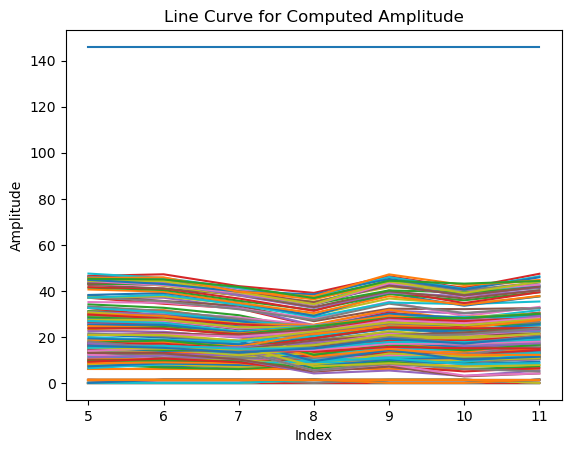

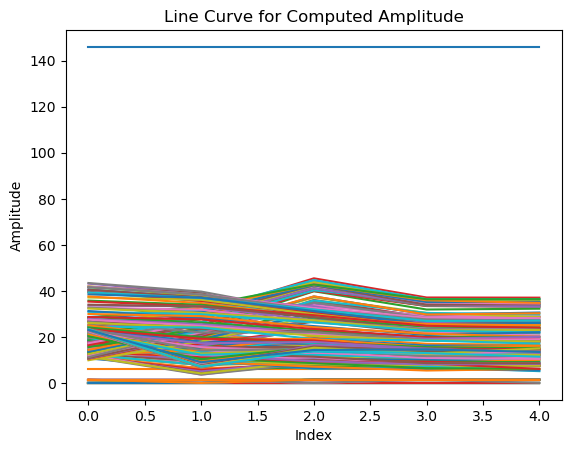

In [417]:
# Write code to display the line curve for computed amplitude.



# Create the line plot
plt.plot(amp[5:12])

# Label the axes
plt.xlabel('Index')
plt.ylabel('Amplitude')

# Set the title
plt.title('Line Curve for Computed Amplitude')

# Show the plot
plt.show()
plt.plot(amp[:5])

# Label the axes
plt.xlabel('Index')
plt.ylabel('Amplitude')

# Set the title
plt.title('Line Curve for Computed Amplitude')

# Show the plot
plt.show()


In [418]:
def drop_subcarrier(df):
    df = df.iloc[0:,64:]
    df.columns = range(df.shape[1])
    delete_idxs =  np.asarray([0,1,2,3,4,5,63,64,65,123,124,125,126,127])
   
    df = df.drop(delete_idxs, axis=1)
    df.columns = range(df.shape[1])
    print("drop_subcarrier completed")
    return df

In [419]:
# Call Here 
amp_dropped =drop_subcarrier(amp)


drop_subcarrier completed


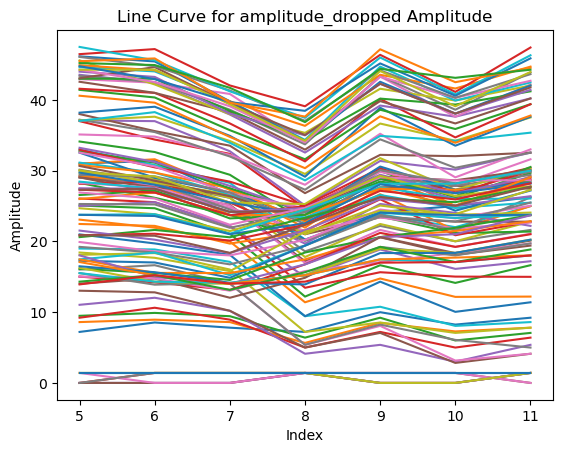

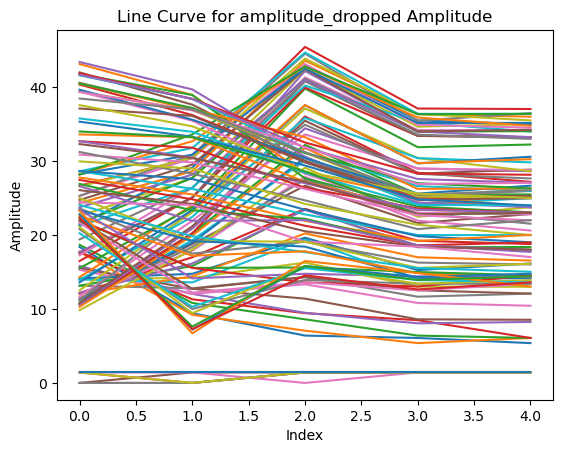

In [420]:
# Write code to display the line curve for computed amplitude.



# Create the line plot
plt.plot(amp_dropped[5:12])

# Label the axes
plt.xlabel('Index')
plt.ylabel('Amplitude')

# Set the title
plt.title('Line Curve for amplitude_dropped Amplitude')

# Show the plot
plt.show()
plt.plot(amp_dropped[:5])

# Label the axes
plt.xlabel('Index')
plt.ylabel('Amplitude')

# Set the title
plt.title('Line Curve for amplitude_dropped Amplitude')

# Show the plot
plt.show()


In [421]:
def Norm(amp): 
    norm_amp=(amp-amp.min())/(amp.max()-amp.min()) # normalize amplitude

    norm_amp = pd.DataFrame(norm_amp)
    
    print("Norm completed") 
    return norm_amp

In [422]:
# Call; here
Normalized_amp=Norm(amp_dropped)

Norm completed


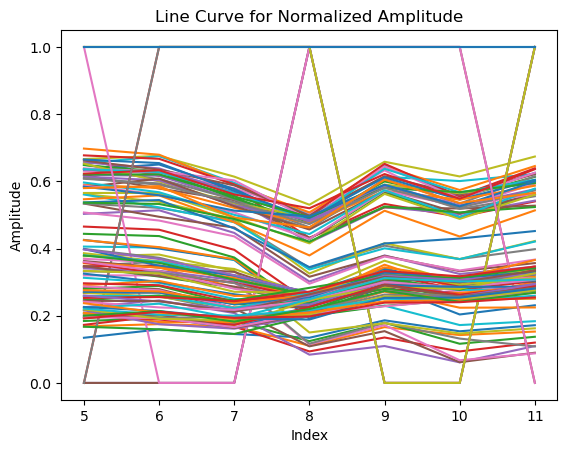

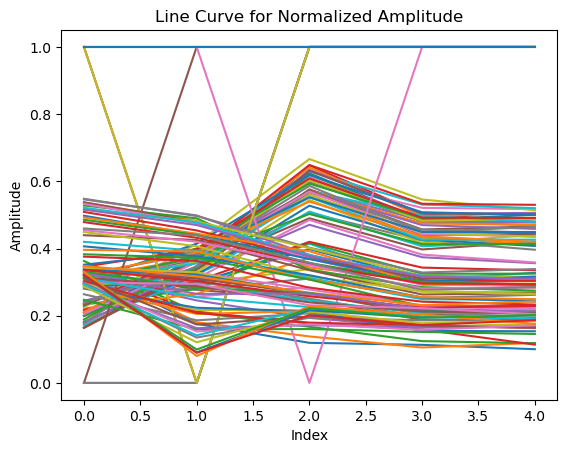

In [423]:
# Write code to display the line curve for computed amplitude.



# Create the line plot
plt.plot(Normalized_amp[5:12])

# Label the axes
plt.xlabel('Index')
plt.ylabel('Amplitude')

# Set the title
plt.title('Line Curve for Normalized Amplitude')

# Show the plot
plt.show()
plt.plot(Normalized_amp[:5])

# Label the axes
plt.xlabel('Index')
plt.ylabel('Amplitude')

# Set the title
plt.title('Line Curve for Normalized Amplitude')

# Show the plot
plt.show()


In [424]:
# outlier removal in amplitude
# def hample_filter(df):
#         fine_df = df.copy()
#         length = len(fine_df)
#         length = int(length/1)
#         for i in fine_df.columns:#range(len(df_amp.iloc[0]))
#             temp = hampel(df[i], window_size=length) # find the optimal window_size
#             fine_df[i]=temp.filtered_data
#         print("hample_filter completed")
#         return fine_df


def hampel_filter(input_matrix):
    input_matrix= np.asarray(input_matrix)
    n = input_matrix.shape[1]
    print(n)
    new_matrix = np.zeros_like(input_matrix)
    k = 1.4826  # scale factor for Gaussian distribution
    n_sigmas=1
    length = len(input_matrix)
    length = int(length/2)
    window_size=length # change the value here
    for ti in range(n):
        
        start_time = max(0, ti - window_size)
        end_time = min(n, ti + window_size)
        x0 = np.nanmedian(input_matrix[:, start_time:end_time], axis=1, keepdims=True)
        s0 = k * np.nanmedian(np.abs(input_matrix[:, start_time:end_time] - x0), axis=1)
        mask = (np.abs(input_matrix[:, ti] - x0[:, 0]) > n_sigmas * s0)
        new_matrix[:, ti] = mask*x0[:, 0] + (1 - mask)*input_matrix[:, ti]
    new_matrix = pd.DataFrame(new_matrix)
    return new_matrix


In [425]:
# call Here
out_rem_amp=hample_filter(Normalized_amp)

hample_filter completed


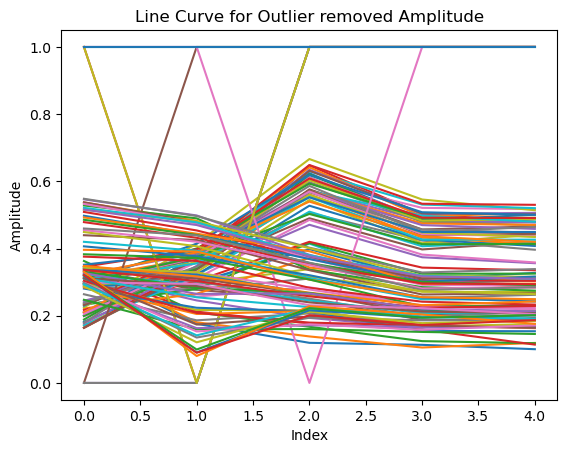

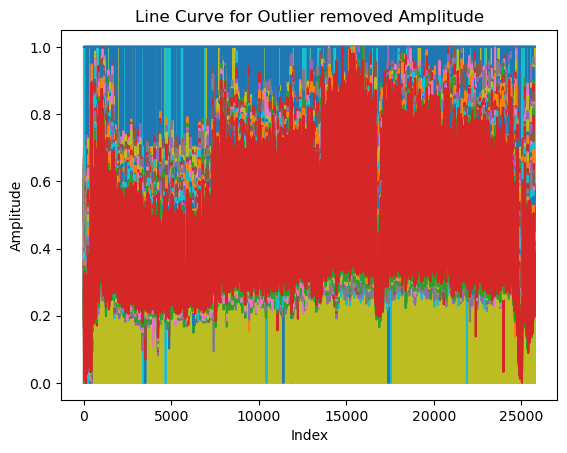

In [426]:
# Write code to display the line curve for computed amplitude.
# Create the line plot
plt.plot(out_rem_amp[:5])

# Label the axes
plt.xlabel('Index')
plt.ylabel('Amplitude')

# Set the title
plt.title('Line Curve for Outlier removed Amplitude')

# Show the plot
plt.show()
plt.plot(out_rem_amp[5:])

# Label the axes
plt.xlabel('Index')
plt.ylabel('Amplitude')

# Set the title
plt.title('Line Curve for Outlier removed Amplitude')

# Show the plot
plt.show()

In [427]:
def denoise(df):
    dwt = pd.DataFrame()
    
    for i in range(len(df.iloc[0])):
        signal = df[i]
        coeff = pywt.wavedec(signal, wavelet='db4', mode="per")
        #coeff
        d = np.mean(np.absolute(coeff[-1] - np.mean(coeff[-1], axis=None)), axis=None)
        sigma = (1/0.6475) * d
        #sigma
        uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
        #uthresh
        coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
        filter = pywt.waverec(coeff, wavelet='db4', mode='per')
        #filter1 = pd.DataFrame(filter)
        dwt[i]= filter
    dwt = dwt[:-1]
    print("denoise completed")
    return dwt

In [428]:
# Call Here
denoised_amp=denoise(out_rem_amp)
print(denoised_amp)


denoise completed
            0         1         2         3         4         5         6    \
0      0.175313  0.186661  0.175509  0.162181  0.180847  0.175287  0.145388   
1      0.172748  0.184338  0.174246  0.161073  0.180285  0.174765  0.145101   
2      0.170095  0.181947  0.172984  0.159981  0.179775  0.174306  0.144882   
3      0.168698  0.180762  0.172803  0.160022  0.180297  0.174993  0.145754   
4      0.168648  0.180877  0.173806  0.161309  0.181965  0.176953  0.147846   
...         ...       ...       ...       ...       ...       ...       ...   
25762  0.189259  0.199387  0.182886  0.168840  0.184729  0.179070  0.147888   
25763  0.187513  0.197776  0.181821  0.167823  0.184016  0.178328  0.147294   
25764  0.185323  0.195778  0.180635  0.166738  0.183362  0.177678  0.146838   
25765  0.182953  0.193614  0.179384  0.165611  0.182705  0.177042  0.146423   
25766  0.180237  0.191139  0.178030  0.164427  0.182082  0.176467  0.146114   

            7         8         9

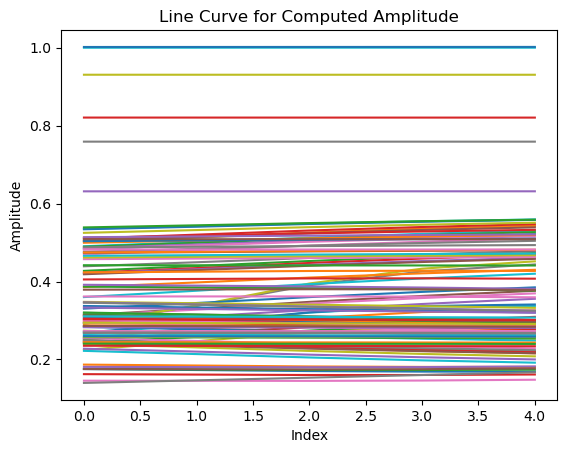

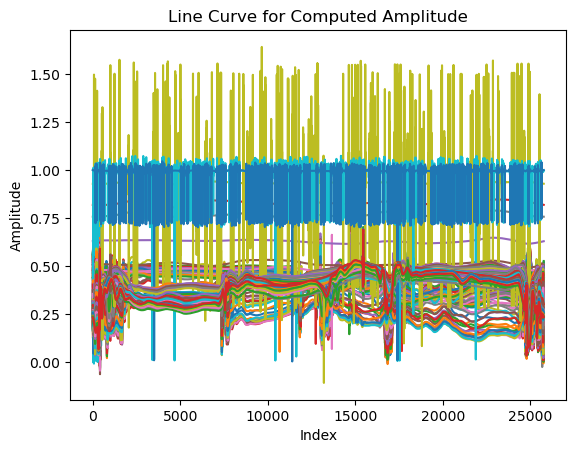

In [429]:
# Write code to display the line curve for computed amplitude.
# Create the line plot
plt.plot(denoised_amp[:5])

# Label the axes
plt.xlabel('Index')
plt.ylabel('Amplitude')

# Set the title
plt.title('Line Curve for Computed Amplitude')

# Show the plot
plt.show()
plt.plot(denoised_amp[5:])

# Label the axes
plt.xlabel('Index')
plt.ylabel('Amplitude')

# Set the title
plt.title('Line Curve for Computed Amplitude')

# Show the plot
plt.show()

In [430]:
# convert timestamp into minute and seconds
def convert_time(data):
    from datetime import datetime
    d = data.copy()
    #df = d["timestamp"]
    time = pd.DataFrame(d)
    for i in range(0, len(time)):       
        dt_obj = datetime.fromtimestamp(int(time[0][i]))
        temp = "%s.%s" % (str(dt_obj.minute).zfill(2),str(dt_obj.second).zfill(2))
        time.loc[i] = float(temp)
        #time.loc[i] = temp
    print("convert time completed")
    return time

In [431]:
# Call here
con_time=convert_time(new_time)
con_time

convert time completed


,0
0,47.21
1,47.22
2,47.23
3,47.23
4,47.23
...,...
25762,56.14
25763,56.14
25764,56.14
25765,56.14


In [432]:
 # apply savgol fiter
def savgol(df,train_time ):
    rd_data = []
    
    N_sample = len(df[0])
    print(N_sample)
    time1 = np.array(train_time)
    time1 = np.unique(time1)
    print(time1.shape[0])
    sam_rate = N_sample+1/time1.shape[0]
    print(sam_rate)
    for i in range(0, len(df.loc[0])):
        rd_ph1 = signal.savgol_filter(df[i], 51,5)
        sos = signal.butter(10,20,'low', fs=2*sam_rate, output='sos')
        rd_ph1 = signal.sosfiltfilt(sos,rd_ph1)
        rd_data.append(rd_ph1)
    smooth = pd.DataFrame(rd_data)
    smooth = smooth.transpose() 
    print("savgol filter completed")    
    return smooth 

In [433]:
# Call Here
smooth_amp=savgol(denoised_amp,con_time)
smooth_amp

25767
534
25767.001872659177
savgol filter completed


,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,0.145094,0.152435,0.140691,0.122951,0.138253,0.118892,0.114085,0.107727,0.254571,0.289948,...,0.291242,0.292960,0.273327,0.276255,0.264631,0.269772,0.267003,0.257742,0.253188,0.248855
1,0.145407,0.152738,0.141029,0.123306,0.138604,0.119261,0.114470,0.108111,0.254726,0.290054,...,0.291301,0.293018,0.273388,0.276329,0.264702,0.269846,0.267077,0.257825,0.253267,0.248937
2,0.145721,0.153042,0.141367,0.123662,0.138955,0.119630,0.114856,0.108495,0.254880,0.290161,...,0.291360,0.293075,0.273449,0.276403,0.264773,0.269919,0.267152,0.257907,0.253345,0.249020
3,0.146035,0.153345,0.141705,0.124018,0.139305,0.119998,0.115241,0.108879,0.255034,0.290267,...,0.291419,0.293133,0.273510,0.276477,0.264845,0.269993,0.267226,0.257989,0.253424,0.249102
4,0.146348,0.153649,0.142043,0.124373,0.139656,0.120367,0.115625,0.109263,0.255188,0.290373,...,0.291478,0.293191,0.273571,0.276551,0.264916,0.270067,0.267300,0.258072,0.253503,0.249185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25762,0.386463,0.385025,0.381602,0.357111,0.368945,0.337049,0.317336,0.303893,0.276631,0.267268,...,0.422752,0.435930,0.413950,0.427521,0.411039,0.424595,0.425672,0.413671,0.402611,0.414406
25763,0.386463,0.385025,0.381602,0.357111,0.368945,0.337049,0.317336,0.303893,0.276631,0.267268,...,0.422752,0.435930,0.413950,0.427521,0.411039,0.424595,0.425672,0.413671,0.402611,0.414406
25764,0.386463,0.385025,0.381602,0.357111,0.368945,0.337049,0.317336,0.303893,0.276631,0.267268,...,0.422752,0.435930,0.413950,0.427521,0.411039,0.424595,0.425672,0.413671,0.402611,0.414406
25765,0.386463,0.385025,0.381602,0.357111,0.368945,0.337049,0.317336,0.303893,0.276631,0.267268,...,0.422752,0.435930,0.413950,0.427521,0.411039,0.424595,0.425672,0.413671,0.402611,0.414406


In [434]:
smooth_amp.shape

(25767, 114)

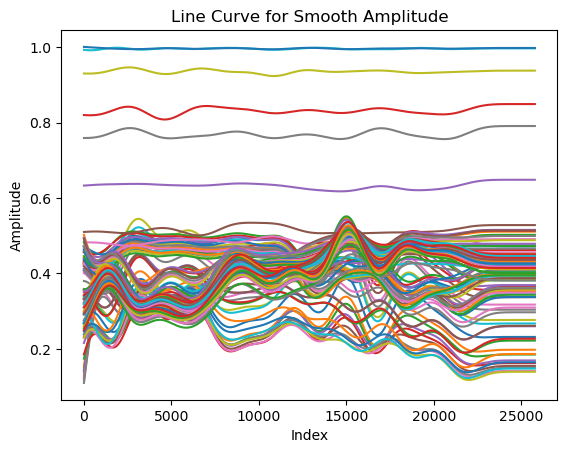

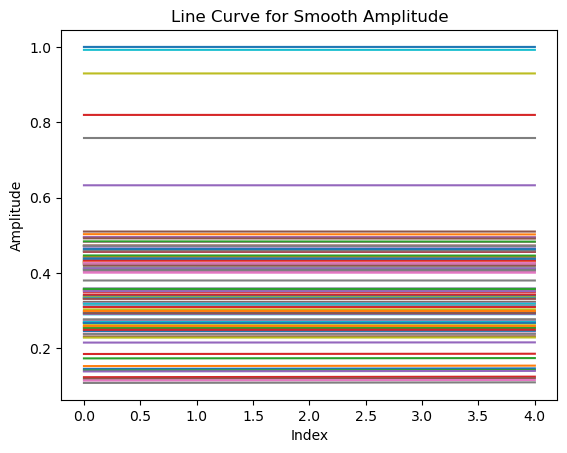

In [435]:
# Write code to display the line curve for computed amplitude.
# Create the line plot
plt.plot(smooth_amp[5:])

# Label the axes
plt.xlabel('Index')
plt.ylabel('Amplitude')

# Set the title
plt.title('Line Curve for Smooth Amplitude')

# Show the plot
plt.show()
plt.plot(smooth_amp[:5])

# Label the axes
plt.xlabel('Index')
plt.ylabel('Amplitude')

# Set the title
plt.title('Line Curve for Smooth Amplitude')

# Show the plot
plt.show()

In [436]:
# Make input shape as: 
# First reduce the column dimension to 100 
# Then make reshape to 10 X 10. 

from sklearn.decomposition import PCA
import pandas as pd

X = smooth_amp.iloc[:, :114].values  


n_components = 100
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
df_reduced = pd.DataFrame(data=X_pca)



In [437]:
df_reduced.shape
ten_data=df_reduced.values.reshape(-1,10,10)
print(ten_data.shape)


(25767, 10, 10)


In [438]:
# # Make input shape as: 
# # First reduce the column dimension to 100 
# # Then make reshape to 10 X 10. 


# df_reduced = smooth_amp.iloc[:, :100]  

# num_rows = len(df_reduced)


# num_complete_matrices = num_rows // 100
# new_num_rows = num_complete_matrices * 100

# df_truncated = df.iloc[:new_num_rows, :]

# # Reshape the truncated DataFrame into 10x10 matrices
# reshaped_arrays = df_truncated.values.reshape(-1, 10, 10)

# # Convert the reshaped arrays back to DataFrame
# reshaped_df = pd.DataFrame(reshaped_arrays.reshape(-1, 10*10))



In [439]:
# defining Attention layer. 
class AttenLayer(tf.keras.layers.Layer):

    def __init__(self, num_state, **kw):
        super(AttenLayer, self).__init__(**kw)
        self.num_state = num_state
    
    def build(self, input_shape):
        self.kernel = self.add_weight('kernel', shape=[input_shape[-1], self.num_state])
        self.bias = self.add_weight('bias', shape=[self.num_state])
        self.prob_kernel = self.add_weight('prob_kernel', shape=[self.num_state])

    def call(self, input_tensor):
        atten_state = tf.tanh(tf.tensordot(input_tensor, self.kernel, axes=1) + self.bias)
        logits = tf.tensordot(atten_state, self.prob_kernel, axes=1)
        prob = tf.nn.softmax(logits)
        weighted_feature = tf.reduce_sum(tf.multiply(input_tensor, tf.expand_dims(prob, -1)), axis=1)
        return weighted_feature
    
    # for saving the model
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_state': self.num_state,})
        return config

In [440]:
# defining Bi-lstm with Attention Layer model 
class CSIModelConfig:
    def __init__(self, win_len=1000, step=200, thrshd=0.6, downsample=2):
        pass
    
    def build_model(self, n_unit_lstm=200, n_unit_atten=400):
        """
        Returns the Tensorflow Model which uses AttenLayer
        """
        if self._downsample > 1:
            length = len(np.ones((self._win_len,))[::self._downsample])
            x_in = tf.keras.Input(shape=(length, 10))
        else:
            x_in = tf.keras.Input(shape=(self._win_len, 10))
        x_tensor = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=n_unit_lstm, return_sequences=True))(x_in)
        x_tensor = AttenLayer(n_unit_atten)(x_tensor)
        pred = tf.keras.layers.Dense(len(self._labels), activation='softmax')(x_tensor)
        model = tf.keras.Model(inputs=x_in, outputs=pred)
        return model
    
    
    @staticmethod
    def load_model(hdf5path):
        """
        Returns the Tensorflow Model for AttenLayer
        Args:
            hdf5path: str, the model file path
        """
        model = tf.keras.models.load_model(hdf5path, custom_objects={'AttenLayer':AttenLayer})
        return model

In [441]:
#loading pretrained model
model = tf.keras.models.load_model('best_atten_400nodes.hdf5',custom_objects={'AttenLayer':AttenLayer})

# input shape required by the model is 10 X 10. 



In [442]:
# predict here
y_pred= model.predict(ten_data)
t1= np.argmax(y_pred, axis=1)
t1 = pd.DataFrame(t1)
t1.columns=['headlabel']
t1.headlabel.replace((0, 1,2, 3,4,5,6),('Forward', 'Looking Up', 'Nodding', 'Looking Down', 'Shaking','Looking Left', 'Looking Right'), inplace=True)

806/806 [==============================] - 11s 13ms/step


In [443]:
t1

,headlabel
0,Shaking
1,Shaking
2,Shaking
3,Shaking
4,Shaking
...,...
25762,Looking Up
25763,Looking Up
25764,Looking Up
25765,Looking Up


In [444]:
# Engagement score calculations
def calc_score(seq):
        score=0
        for i in seq:
            if(i==1 or i==2 or i==3):
                score+=1
            elif(i==6 or i==7 or i==5):
                score-=1
            elif(i==4):
                score+=0.8
            elif(i==8):
                score-=1
            # else:
            #     score+=0.5
        return score/len(seq)
def engagement_score(time, t1):
    headlabel_rank={'Forward':1, 'Nodding':2, 'Shaking':3, 'Looking Down':4, 'Looking Up':5, 'Looking Left':6, 'Looking Right':7, 'Unknown Gesture':8}
    time.columns= ['timestamp']
    end_time=time['timestamp'][time.shape[0]-1]
    start_time=time['timestamp'][0]
    total_time=end_time-start_time
    windows=total_time//2 # /10 
    windows=math.floor(windows)

    window_size=(time.shape[0]+1)/windows
    window_size=math.floor(window_size)
    
    window_size=34 
    if(t1.shape[0]==41595):
        window_size=3
    
    headlabels=[]

    for label in t1['headlabel']:
        headlabels.append(headlabel_rank[label])
    Windows=[]
    index=0
    for i in range(windows):
        Window=[]
        for j in range(window_size):
            try:
                Window.append(headlabels[index])
                index=index+1
            except:
                print("")
        Windows.append(Window)
    Windows_index=collections.deque()
    for i in range(len(Windows)):
        Windows_index.append(i)

    Clusters=[]

    while(len(Windows_index)>0):

        Cluster=[]
        first_index=Windows_index.popleft()
        Window=Windows[first_index]
        Cluster.append((first_index,Window))
        indexes=[]
        for index in Windows_index:
            sm=difflib.SequenceMatcher(None,Window,Windows[index])
            if(sm.ratio()>0.70): # similarity score
                indexes.append(index)
                Cluster.append((index,Windows[index]))
        for index in indexes:
            Windows_index.remove(index)
        Clusters.append(Cluster)
    scores=[0]*windows
    for cluster in Clusters:
        temp_score=[]
        for j in cluster:
            seq_score=calc_score(j[1])
            temp_score.append(seq_score)
        #sequence=cluster[0][1]
        #score=calc_score(sequence)
        score=max(temp_score)
        for seq in cluster:
            index=seq[0]
            scores[index]=score
    thresholds=[0.55]

    model_eng=[]
    window=[]
    for threshold in thresholds:
        win=0
        engaged=[]
        print("threshold: ",threshold)
        for i in scores:
            if(i>=threshold): # threshold for enumerating engage or disengage. 
                engaged.append(1)
                model_eng.append(1)
                win=win+1
                window.append(win)
            else:
                engaged.append(0)
                model_eng.append(0)
                win=win+1
                window.append(win)
    print(sum(engaged)/len(engaged))

In [445]:
# call Here
engagement_score(con_time,t1)

threshold:  0.55
0.75
